In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from astropy.time import Time
import numpy as np
from astropy.coordinates import Distance
from astropy import units as u
from astropy import constants as const
from radio_utils import equipartition_energy, equipartition_radius, equipartition_beta, dates, peak_f, peak_flux, get_delta_times, calc_av_expansion
from flux_utils import flux_conversion
from plots import fontsize, fig_width
from data import meerkat_data, vla_data, t_peak_mjd, t_neutrino, bran_z, bran_disc, asassn_14li_data, asassn_14li_z, asassn_14li_t0, asassn_14li_disc, xmmsl1_data, xmmsl1_z

In [2]:
# Cross check with table 2 of the paper, using row 2 of the spherical section

print("Checking formula using values from https://arxiv.org/abs/1510.01226")

print("Distance to ASASSN-14li: {0:.2f} \n".format(Distance(z=asassn_14li_z).to(u.Mpc)))

published_r_s = 1.47 * 10**16 * u.cm
calc_r_s = equipartition_radius(8.20, 1.76, z=asassn_14li_z)
published_e_s = 7.8 * 10**47 * u.erg
calc_e_s = equipartition_energy(8.20, 1.76, z=asassn_14li_z)
published_e_b = 1.0
calc_b_s = equipartition_beta(8.20, 1.76, z=asassn_14li_z, delta_t=asassn_14li_data.T[0][0]*u.day)
published_b_s = 0.04

print(calc_b_s)
    
published_r_c = 4.37 * 10**16 * u.cm
calc_r_c = equipartition_radius(8.20, 1.76, z=asassn_14li_z, f_a=0.1)
published_e_c = 3.19 * 10**47 * u.erg
calc_e_c = equipartition_energy(8.20, 1.76, z=asassn_14li_z, f_a=0.1)

# published_e = 9.5 * 10**47 * u.erg
# calc_e = equipartition_energy(4.37, 1.23, z=asassn_14li_z)

print("Spherical Case")

print("Checking with ASSASSN-14li, we should have Equipartition Radius of {0:.3g}.".format(published_r_s))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_r_s, calc_r_s/published_r_s))
print("Checking with ASSASSN-14li, we should have Equipartition Energy of {0:.3g}.".format(published_e_s))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_e_s, calc_e_s/published_e_s))
print("Checking with ASSASSN-14li, we should have Equipartition Beta of {0:.3g}.".format(published_b_s))
print("We find {0:.3g}, a ratio of {1:.2f} \n".format(calc_b_s, calc_b_s/published_b_s))

print("Conical Case")

print("Checking with ASSASSN-14li, we should have Equipartition Radius of {0:.3g}.".format(published_r_c))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_r_c, calc_r_c/published_r_c))
print("Checking with ASSASSN-14li, we should have Equipartition Energy of {0:.3g}.".format(published_e_c))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_e_c, calc_e_c/published_e_c))

Checking formula using values from https://arxiv.org/abs/1510.01226
Distance to ASASSN-14li: 92.60 Mpc 

0.03934670492800024
Spherical Case
Checking with ASSASSN-14li, we should have Equipartition Radius of 1.47e+16 cm.
We find 1.49e+16 cm, a ratio of 1.01
Checking with ASSASSN-14li, we should have Equipartition Energy of 7.8e+47 erg.
We find 7.67e+47 erg, a ratio of 0.98
Checking with ASSASSN-14li, we should have Equipartition Beta of 0.04.
We find 0.0393, a ratio of 0.98 

Conical Case
Checking with ASSASSN-14li, we should have Equipartition Radius of 4.37e+16 cm.
We find 4.42e+16 cm, a ratio of 1.01
Checking with ASSASSN-14li, we should have Equipartition Energy of 3.19e+47 erg.
We find 1.25e+48 erg, a ratio of 3.91


Text(0.5, 0, 'Time since peak (days)')

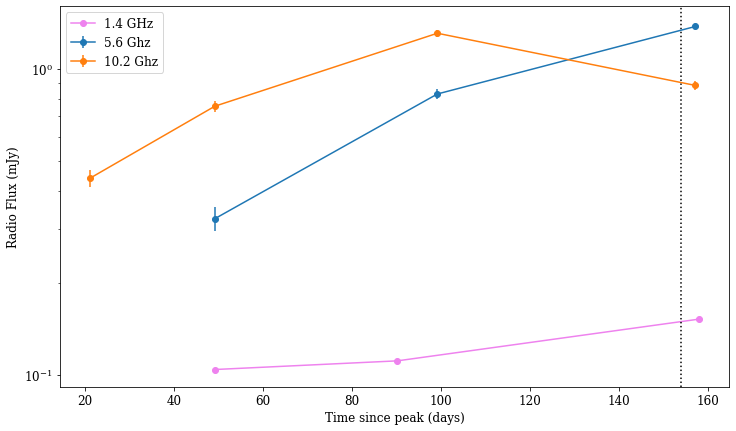

In [3]:
plt.figure(figsize=(12, 7))

# Radio Data

ax3 = plt.subplot(111)
ax3.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, meerkat_data["flux_mJy"], marker="o", color="violet", label="1.4 GHz")
ax3.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    ax3.errorbar(data["mjd"]- t_peak_mjd.mjd, data["flux"],  yerr=data["flux_err"], marker="o", label="{0} Ghz".format(frequency))

ax3.legend(fontsize=12)
ax3.set_ylabel("Radio Flux (mJy)", fontsize=12)
ax3.set_yscale("log")
ax3.tick_params(axis='both', which='both', labelsize=12)
plt.xlabel("Time since peak (days)", fontsize=12)

Launch date was 2019-01-12T07:02:36.806


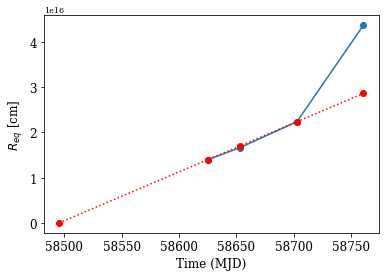

In [4]:
r_vals = np.array([x.value for x in equipartition_radius(peak_f, peak_flux)])
plt.figure()
plt.plot(dates, r_vals, marker="o")
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel(r"$R_{eq}$ [cm]", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# plt.yscale("log")

fixed_index = 2


grad = (r_vals[fixed_index] - r_vals[0])/(dates[fixed_index] - dates[0])
c = r_vals[0] - grad*dates[0]

def fit_r(t):
    return grad*np.array(t) + c

fit_t0 = Time(-c/grad, format="mjd")

plt.plot([fit_t0.mjd] + list(dates), fit_r([fit_t0.mjd] + list(dates)), marker="o", linestyle=":", color="r")

print(f"Launch date was {fit_t0.isot}")

In [5]:
# From fit to radio spectrum
peak_f = np.array([14.196014242837597, 12.201382623396936, 9.975065596668484, 5.56672580824371])
peak_flux = np.array([0.46810052872218944, 0.7843435869242245, 1.2767596314937135, 1.3292357335313087])


<ipython-input-7-12583165547d>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4 = plt.subplot(311)


[8.00394618e+47 1.73948968e+48 3.83765467e+48 7.22033579e+48] erg
[1.0627270099667944e+16, 1.578932522969842e+16, 2.432706739917825e+16, 4.4431582564269144e+16]


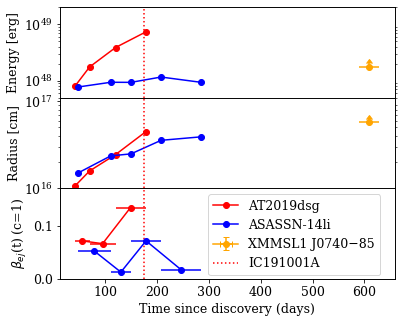

In [7]:
plt.figure(figsize=(fig_width, fig_width * 5./6.))


fit_t0 = bran_disc

ax1 = plt.subplot(311)

offset_times = dates[:-1] + 0.5 * get_delta_times(dates) / u.day

# Equipartition Energy

ax4 = plt.subplot(311)
ax4b = ax4.twinx()

li_offset = asassn_14li_disc.mjd - asassn_14li_t0.mjd

# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux),  marker="o", color="gray", label=r"Spherical ($f_{A}=1.0$)")
# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="gray", label=r"Conical ($f_{A}=0.1$)")
l1 = ax4.plot(
    dates - fit_t0.mjd,
    equipartition_energy(peak_f, peak_flux),
    marker="o",
    color="red",
    label=r"AT2019dsg"
)

print(equipartition_energy(peak_f, peak_flux))

# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", color="blue", label=r"Conical ($f_{A}=0.1$)")

l2 = ax4.plot(
    asassn_14li_data.T[0] - li_offset,
    equipartition_energy(asassn_14li_data.T[1], asassn_14li_data.T[2], z=asassn_14li_z),
    marker="o",
    color="blue",
    label=r"ASASSN-14li"
)

y = equipartition_energy(xmmsl1_data.T[1][0], xmmsl1_data.T[2][0], z=xmmsl1_z).value

l3 = ax4.errorbar(
    xmmsl1_data.T[0][0],
    y,
    yerr=0.2*y,
    lolims=True,
    xerr=20.,
    marker="o",
    color="orange",
    label=r"XMMSL1 J0740−85"
)

l4 = ax4.axvline(t_neutrino.mjd - fit_t0.mjd, color="r", linestyle=":", label="IC191001A")
ax4.set_ylabel("Energy [erg]", fontsize=fontsize)

handles, labels = ax4.get_legend_handles_labels()

handles = [handles[0], handles[1], handles[3], handles[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]

ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax4.set_ylim(5.*10**47, 2.*10.**49)
ax4b.set_ylim(5.*10**47, 2.*10.**49)
ax4.set_yscale("log")
ax4b.set_yscale("log")
ax4b.get_yaxis().set_ticks([])

# Equipartition Radius

ax5 = plt.subplot(312, sharex=ax4)
ax5b = ax5.twinx()
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux), marker="o", color="brown", label=r"Spherical ($f_{A}=1.0$)")
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="brown", label=r"Conical ($f_{A}=0.1$)")
ax5.plot(
    dates - fit_t0.mjd,
    [x.value for x in equipartition_radius(peak_f, peak_flux)],
    marker="o",
    color="red",
    label=r"Spherical ($f_{A}=1.0$)"
)

print([x.value for x in equipartition_radius(peak_f, peak_flux)])

ax5.plot(
    asassn_14li_data.T[0]  - li_offset,
    [x.value for x in equipartition_radius(asassn_14li_data.T[1], asassn_14li_data.T[2], z=asassn_14li_z)],
    marker="o",
    color="blue",
    label=r"Spherical ($f_{A}=1.0$)"
)

y = equipartition_radius(xmmsl1_data.T[1][0], xmmsl1_data.T[2][0], z=xmmsl1_z).value

ax5.errorbar(
    xmmsl1_data.T[0][0],
    y,
    yerr=0.1*y,
    xerr=20.,
    lolims=True,
    marker="o",
    color="orange",
    label=r"XMMSL1 J0740−85 (Spherical)"
)
# print(equipartition_radius(asassn_14li_data.T[1], asassn_14li_data.T[2], z=asassn_14li_z))
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", color="blue", label=r"Conical ($f_{A}=0.1$)")

ax5.axvline(t_neutrino.mjd - fit_t0.mjd, color="r", linestyle=":", label="IC191001A")
ax5.set_yscale("log")
ax5.set_ylabel("Radius [cm]", fontsize=fontsize)
# ax5.legend(fontsize=16)
ax5.tick_params(axis='both', which='both', labelsize=fontsize)
# ax5.ticklabel_format(axis='both', style="sci")
ax5.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax5.set_ylim(10**16, 1.1* 10.**17)
ax5b.set_ylim(10**16, 1.1* 10.**17)
ax5b.set_yscale("log")
ax5b.get_yaxis().set_ticks([])



# Average Expansion Velocity

delta_times = get_delta_times()


ax6 = plt.subplot(313, sharex=ax4)
ax6b = ax6.twinx()

# eb1 = ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=0.1)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", marker="*", label=r"Conical ($f_{A}=0.1$)")
# eb1[-1][0].set_linestyle(':')

bran_y = [x.value for x in calc_av_expansion(peak_f, peak_flux)/(3 * 10 ** 8)]

ax6.errorbar(
    0.5*get_delta_times(dates)/u.day + dates[:-1] - fit_t0.mjd,
    bran_y,
#     equipartition_beta(peak_f, peak_flux, delta_t=(dates - fit_t0.mjd)*u.day),
    xerr=0.5 * get_delta_times(dates) / u.day,
#     fmt="o",
    marker="o",
    color="red",
    label=r"Spherical ($f_{A}=1.0$)"
)

# y = [
#     g.value for g in calc_av_expansion(
#         asassn_14li_data.T[1],
#         asassn_14li_data.T[2],
#         times=asassn_14li_data.T[0],
#         z=asassn_14li_z,
#         f_a=1.0,
#     )/(3*10**8)
# ]

offset_t = (0.5*get_delta_times(asassn_14li_data.T[0])/u.day + asassn_14li_data.T[0][:-1] - li_offset)
y = [x.value for x in calc_av_expansion(asassn_14li_data.T[1], asassn_14li_data.T[2], z=asassn_14li_z, times=asassn_14li_data.T[0])/(3 * 10 ** 8)]
# t = np.array([x.value for x in get_delta_times(asassn_14li_data.T[0])])
# offset_t = asassn_14li_data.T[0][:-1] + 0.5 * t

ax6.errorbar(
    offset_t,
    y,
    xerr=0.5 * get_delta_times(asassn_14li_data.T[0]) / u.day,
#     fmt="o",
    marker="o",
    color="blue",
    label=r"Spherical ($f_{A}=1.0$)"
)

offset_t = (0.5*get_delta_times(xmmsl1_data.T[0])/u.day + xmmsl1_data.T[0][:-1])
y = [x.value for x in calc_av_expansion(xmmsl1_data.T[1], xmmsl1_data.T[2], z=xmmsl1_z, times=xmmsl1_data.T[0])/(3 * 10 ** 8)]

# ax6.errorbar(
#     offset_t,
#     y,
# #     equipartition_beta(xmmsl1_data.T[1], xmmsl1_data.T[2], z=xmmsl1_z, delta_t=xmmsl1_data.T[0]*u.day),
#     xerr=0.5 * get_delta_times(xmmsl1_data.T[0]) / u.day,
# #     fmt="o",
#     marker="o",
#     color="orange",
#     label=r"Spherical ($f_{A}=1.0$)"
# )
# eb1 = ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=0.1)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", marker="*", label=r"Conical ($f_{A}=0.1$)")

ax6.axvline(t_neutrino.mjd - fit_t0.mjd, color="r", linestyle=":", label="IC191001A")
ax6.set_ylabel(r"$\beta_{ej}$(t) (c=1)", fontsize=fontsize)
ax6.legend(handles, labels, fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.45, 0.5, 0.5, 0.5))

# ax6.legend(fontsize=16)
ax6.set_ylim(0.0, 0.17)
ax6b.set_ylim(0.0, 0.17)
ax6b.get_yaxis().set_ticks([])

ax6.set_xlabel("Time since discovery (days)", fontsize=fontsize)
ax6.tick_params(axis='both', which='both', labelsize=fontsize)



# plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.savefig("plots/equipartition.pdf")